# 서울시 편의점 매출 결정요인 분석

---

## Executive Summary

본 프로젝트는 서울시 편의점 매출을 결정하는 핵심 요인을 데이터 기반으로 분석하여,  
**신규 출점 입지 선정** 및 **기존 점포 운영 전략** 수립에 활용할 수 있는 인사이트를 도출하는 것을 목표로 합니다.

### 핵심 발견
- **상권유형**이 매출에 가장 큰 영향 (관광특구 > 발달상권 > 전통시장 > 골목상권)
- **점포수**와 **유동인구**가 매출과 강한 양의 상관관계
- 머신러닝 모델(RandomForest)이 매출 예측에서 R²=0.86 달성

### 분석 흐름
```
1. 프로젝트 개요 → 2. 데이터 소개 → 3. EDA/가설검증 → 4. 회귀분석 
→ 5. 머신러닝 예측 → 6. What-if 시나리오 → 7. 인사이트 → 8. 결론/제언
```

---

# 1. 프로젝트 개요

## 1.1 배경
- 서울시 편의점 시장의 **경쟁 심화** (2024년 기준 약 1만 4천개 이상)
- 신규 출점 시 **입지 선정의 중요성** 증가
- 데이터 기반 의사결정의 필요성

## 1.2 목적
1. 편의점 매출에 영향을 미치는 **핵심 요인 파악**
2. 상권유형별 **매출 차이 검증**
3. **신규 출점/운영 전략**에 대한 실무적 제언 도출

## 1.3 연구 질문 및 가설

**연구 질문**: 서울시 편의점 매출을 결정하는 핵심 요인은 무엇인가?

| 가설 | 내용 |
|------|------|
| H1 | 유동인구가 많을수록 매출이 높다 |
| H2 | 점포수(밀집도)가 높을수록 매출이 높다 |
| H3 | 상권유형에 따라 매출 차이가 있다 |

---

# 2. 환경 설정 및 데이터 로드

In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 통계/회귀 분석
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 머신러닝
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 한글 폰트 설정
from matplotlib import font_manager
candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR"]
available = {f.name for f in font_manager.fontManager.ttflist}
for c in candidates:
    if c in available:
        plt.rcParams["font.family"] = c
        break
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams['figure.figsize'] = (10, 6)

# outputs 폴더 생성
import os
os.makedirs('./outputs', exist_ok=True)

print("환경 설정 완료")

환경 설정 완료


In [2]:
# 데이터 로드
df = pd.read_csv('분석데이터.csv', encoding='utf-8')
print(f"데이터 로드 완료: {len(df):,}건")
print(f"기간: {df['기준_년분기_코드'].min()} ~ {df['기준_년분기_코드'].max()}")
print(f"분기 수: {df['기준_년분기_코드'].nunique()}개")

데이터 로드 완료: 6,097건
기간: 20221 ~ 20253
분기 수: 15개


# 3. 데이터 소개

## 3.1 데이터 출처 및 구조

In [3]:
print("=" * 60)
print("데이터 개요")
print("=" * 60)
print(f"""
[데이터 출처]
  - 서울시 상권분석 서비스 (서울 열린데이터광장)
  
[분석 단위]
  - 행정동 × 분기 (Raw 데이터를 Group By 집계)
  
[분석 기간]
  - 2022년 1분기 ~ 2025년 3분기 ({df['기준_년분기_코드'].nunique()}개 분기)
  
[데이터 규모]
  - 행: {len(df):,}건
  - 열: {len(df.columns)}개
""")

print("\n[변수 설명]")
print("-" * 60)
var_desc = {
    '기준_년분기_코드': '분석 기준 년도+분기 (예: 20221 = 2022년 1분기)',
    '행정동_코드': '행정동 고유 코드',
    '행정동_코드_명': '행정동 이름',
    '당월_매출_금액': '해당 분기 편의점 총 매출액 (원) - [종속변수]',
    '당월_매출_건수': '해당 분기 총 매출 건수',
    '점포_수': '해당 행정동 편의점 수 - [독립변수]',
    '총_유동인구_수': '해당 행정동 총 유동인구 - [독립변수]',
    '주요_상권유형': '상권 분류 (골목/발달/관광특구/전통시장/미분류) - [독립변수]',
    '연도': '연도',
    '분기': '분기'
}
for col, desc in var_desc.items():
    print(f"  {col}: {desc}")

데이터 개요

[데이터 출처]
  - 서울시 상권분석 서비스 (서울 열린데이터광장)

[분석 단위]
  - 행정동 × 분기 (Raw 데이터를 Group By 집계)

[분석 기간]
  - 2022년 1분기 ~ 2025년 3분기 (15개 분기)

[데이터 규모]
  - 행: 6,097건
  - 열: 10개


[변수 설명]
------------------------------------------------------------
  기준_년분기_코드: 분석 기준 년도+분기 (예: 20221 = 2022년 1분기)
  행정동_코드: 행정동 고유 코드
  행정동_코드_명: 행정동 이름
  당월_매출_금액: 해당 분기 편의점 총 매출액 (원) - [종속변수]
  당월_매출_건수: 해당 분기 총 매출 건수
  점포_수: 해당 행정동 편의점 수 - [독립변수]
  총_유동인구_수: 해당 행정동 총 유동인구 - [독립변수]
  주요_상권유형: 상권 분류 (골목/발달/관광특구/전통시장/미분류) - [독립변수]
  연도: 연도
  분기: 분기


In [4]:
# 데이터 미리보기
print("\n[데이터 미리보기]")
df.head()


[데이터 미리보기]


,기준_년분기_코드,행정동_코드,행정동_코드_명,당월_매출_금액,당월_매출_건수,점포_수,총_유동인구_수,주요_상권유형,연도,분기
0,20221,11110515,청운효자동,1.202573e+09,179263,4,3627519,골목상권,2022,1
1,20221,11110530,사직동,3.761850e+09,659962,4,3402653,골목상권,2022,1
2,20221,11110540,삼청동,1.226802e+09,138702,1,821735,발달상권,2022,1
3,20221,11110550,부암동,6.070565e+08,79978,2,1283546,골목상권,2022,1
4,20221,11110560,평창동,5.689599e+08,72916,3,823714,골목상권,2022,1


## 3.2 데이터 품질 검증

In [5]:
print("=" * 60)
print("데이터 품질 검증")
print("=" * 60)

# 결측치 확인
print("\n[1] 결측치 현황")
missing = df.isna().sum()
if missing.sum() == 0:
    print("  → 결측치 없음 ✓")
else:
    print(missing[missing > 0])

# 중복행 확인
print(f"\n[2] 중복행: {df.duplicated().sum()}건")

# 이상 징후 체크
print("\n[3] 데이터 무결성 체크")
checks = {
    '점포수=0인데 매출>0': len(df[(df['점포_수']==0) & (df['당월_매출_금액']>0)]),
    '매출<=0': len(df[df['당월_매출_금액']<=0]),
    '유동인구<=0': len(df[df['총_유동인구_수']<=0]),
}
for check, count in checks.items():
    status = '⚠️ 확인필요' if count > 0 else '✓'
    print(f"  {check}: {count}건 {status}")

if checks['점포수=0인데 매출>0'] > 0:
    print("\n  ※ 점포수=0인데 매출이 있는 경우:")
    print("     집계 시점 차이 또는 데이터 매핑 이슈로 추정")
    print("     분석에는 포함하되, 해석 시 주의 필요")

데이터 품질 검증

[1] 결측치 현황
  → 결측치 없음 ✓

[2] 중복행: 0건

[3] 데이터 무결성 체크
  점포수=0인데 매출>0: 267건 ⚠️ 확인필요
  매출<=0: 0건 ✓
  유동인구<=0: 0건 ✓

  ※ 점포수=0인데 매출이 있는 경우:
     집계 시점 차이 또는 데이터 매핑 이슈로 추정
     분석에는 포함하되, 해석 시 주의 필요


In [6]:
# 상권유형별 샘플 수 (불균형 확인)
print("\n[4] 상권유형별 샘플 수")
type_counts = df['주요_상권유형'].value_counts()
print(type_counts.to_frame('건수'))
print(f"\n  → 골목상권이 {type_counts['골목상권']/len(df)*100:.1f}%로 다수")
print("  → 불균형 데이터이나, 실제 서울시 상권 분포를 반영")


[4] 상권유형별 샘플 수
           건수
주요_상권유형      
골목상권     5137
미분류       339
발달상권      300
전통시장      231
관광특구       90

  → 골목상권이 84.3%로 다수
  → 불균형 데이터이나, 실제 서울시 상권 분포를 반영


---
# 4. 탐색적 데이터 분석 (EDA) 및 가설 검증

## 4.1 종속변수 탐색: 매출 분포

In [7]:
sales = df['당월_매출_금액']

print("=" * 60)
print("종속변수: 당월 매출 금액")
print("=" * 60)
print(f"""
[기초 통계량]
  평균: {sales.mean()/1e8:.2f}억원
  중앙값: {sales.median()/1e8:.2f}억원
  표준편차: {sales.std()/1e8:.2f}억원
  최소: {sales.min()/1e8:.2f}억원
  최대: {sales.max()/1e8:.2f}억원

[분포 특성]
  왜도(Skewness): {sales.skew():.2f}
  첨도(Kurtosis): {sales.kurtosis():.2f}
  평균/중앙값 비율: {sales.mean()/sales.median():.2f}
""")

if sales.skew() > 1:
    print("  → 오른쪽 꼬리가 긴 분포 (고매출 지역이 소수 존재)")
    print("  → 이분산(Heteroscedasticity) 가능성 → Robust SE 사용 권장")

종속변수: 당월 매출 금액

[기초 통계량]
  평균: 27.11억원
  중앙값: 17.19억원
  표준편차: 32.01억원
  최소: 0.00억원
  최대: 351.91억원

[분포 특성]
  왜도(Skewness): 3.92
  첨도(Kurtosis): 23.46
  평균/중앙값 비율: 1.58

  → 오른쪽 꼬리가 긴 분포 (고매출 지역이 소수 존재)
  → 이분산(Heteroscedasticity) 가능성 → Robust SE 사용 권장


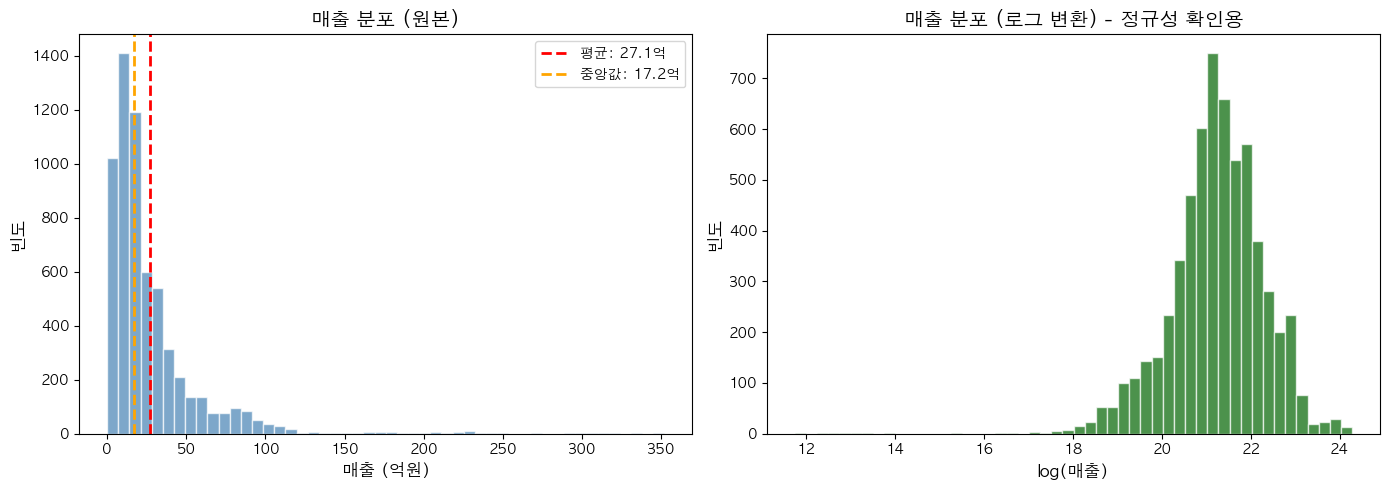

→ 저장: ./outputs/01_매출분포.png


In [8]:
# 매출 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 원본 분포
axes[0].hist(df['당월_매출_금액']/1e8, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].axvline(sales.mean()/1e8, color='red', linestyle='--', linewidth=2, label=f'평균: {sales.mean()/1e8:.1f}억')
axes[0].axvline(sales.median()/1e8, color='orange', linestyle='--', linewidth=2, label=f'중앙값: {sales.median()/1e8:.1f}억')
axes[0].set_xlabel('매출 (억원)', fontsize=12)
axes[0].set_ylabel('빈도', fontsize=12)
axes[0].set_title('매출 분포 (원본)', fontsize=14, fontweight='bold')
axes[0].legend()

# 로그 변환 분포
axes[1].hist(np.log1p(df['당월_매출_금액']), bins=50, color='darkgreen', edgecolor='white', alpha=0.7)
axes[1].set_xlabel('log(매출)', fontsize=12)
axes[1].set_ylabel('빈도', fontsize=12)
axes[1].set_title('매출 분포 (로그 변환) - 정규성 확인용', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./outputs/01_매출분포.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ 저장: ./outputs/01_매출분포.png")

## 4.2 가설 H1 검증: 유동인구 → 매출

**H1: 유동인구가 많을수록 매출이 높다**

In [9]:
# 상관관계 분석
corr_h1, pval_h1 = stats.pearsonr(df['총_유동인구_수'], df['당월_매출_금액'])

print("=" * 60)
print("H1 검증: 유동인구 → 매출")
print("=" * 60)
print(f"""
[상관분석 결과]
  Pearson 상관계수: r = {corr_h1:.4f}
  p-value: {pval_h1:.2e}
  
[해석]
  상관 강도: {'강한' if abs(corr_h1) > 0.7 else '중간' if abs(corr_h1) > 0.4 else '약한'} 양의 상관
  통계적 유의성: {'유의함 (p < 0.05)' if pval_h1 < 0.05 else '유의하지 않음'}
  
[결론] H1 {'채택' if pval_h1 < 0.05 and corr_h1 > 0 else '기각'}: 유동인구가 많을수록 매출이 높다
""")

H1 검증: 유동인구 → 매출

[상관분석 결과]
  Pearson 상관계수: r = 0.4991
  p-value: 0.00e+00

[해석]
  상관 강도: 중간 양의 상관
  통계적 유의성: 유의함 (p < 0.05)

[결론] H1 채택: 유동인구가 많을수록 매출이 높다



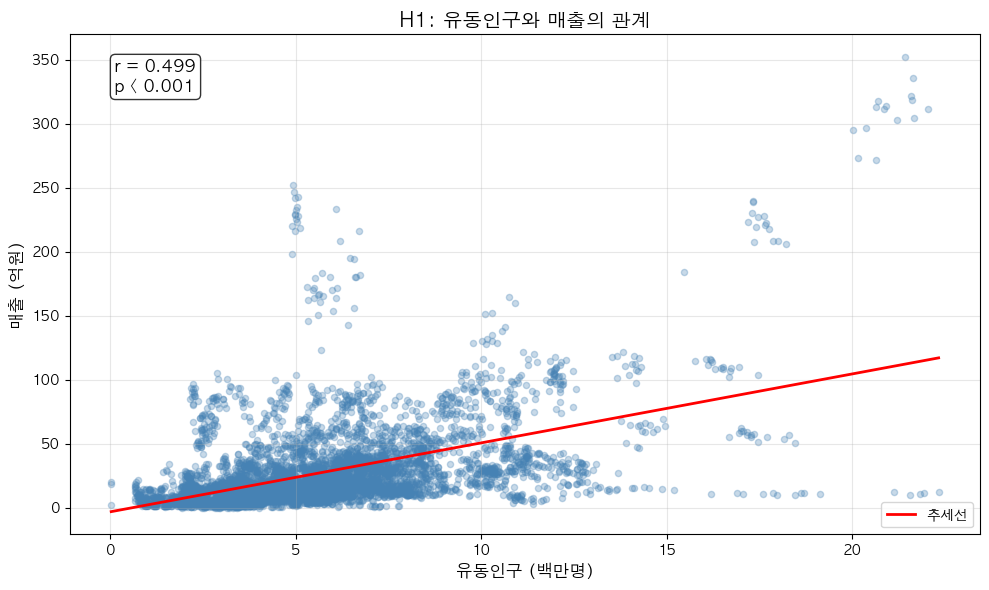

→ 유동인구가 많을수록 매출이 높아지는 경향 확인
→ 저장: ./outputs/02_H1_유동인구_매출.png


In [10]:
# H1 시각화: 유동인구 vs 매출 산점도
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(df['총_유동인구_수']/1e6, df['당월_매출_금액']/1e8, 
           alpha=0.3, s=20, color='steelblue')

# 추세선
z = np.polyfit(df['총_유동인구_수'], df['당월_매출_금액'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['총_유동인구_수'].min(), df['총_유동인구_수'].max(), 100)
ax.plot(x_line/1e6, p(x_line)/1e8, color='red', linewidth=2, label='추세선')

# 상관계수 표시
ax.text(0.05, 0.95, f'r = {corr_h1:.3f}\np < 0.001', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('유동인구 (백만명)', fontsize=12)
ax.set_ylabel('매출 (억원)', fontsize=12)
ax.set_title('H1: 유동인구와 매출의 관계', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/02_H1_유동인구_매출.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"→ 유동인구가 많을수록 매출이 높아지는 경향 확인")
print("→ 저장: ./outputs/02_H1_유동인구_매출.png")

## 4.3 가설 H2 검증: 점포수 → 매출

**H2: 점포수(밀집도)가 높을수록 매출이 높다**

> ⚠️ 주의: 점포가 많으면 총 매출이 높아지는 것은 당연할 수 있음.  
> 이는 "수요가 있는 곳에 점포가 많이 생긴다"는 **역인과 가능성**도 존재.

In [11]:
# 상관관계 분석
corr_h2, pval_h2 = stats.pearsonr(df['점포_수'], df['당월_매출_금액'])

print("=" * 60)
print("H2 검증: 점포수 → 매출")
print("=" * 60)
print(f"""
[상관분석 결과]
  Pearson 상관계수: r = {corr_h2:.4f}
  p-value: {pval_h2:.2e}
  
[해석]
  상관 강도: {'강한' if abs(corr_h2) > 0.7 else '중간' if abs(corr_h2) > 0.4 else '약한'} 양의 상관
  통계적 유의성: {'유의함 (p < 0.05)' if pval_h2 < 0.05 else '유의하지 않음'}
  
[결론] H2 {'채택' if pval_h2 < 0.05 and corr_h2 > 0 else '기각'}: 점포수가 많을수록 매출이 높다

[주의사항]
  - 이 결과가 "점포를 늘리면 매출이 오른다"를 의미하지 않음
  - 수요가 있는 곳에 점포가 많이 생긴 것일 수 있음 (역인과)
  - 상관관계 ≠ 인과관계
""")

H2 검증: 점포수 → 매출

[상관분석 결과]
  Pearson 상관계수: r = 0.8065
  p-value: 0.00e+00

[해석]
  상관 강도: 강한 양의 상관
  통계적 유의성: 유의함 (p < 0.05)

[결론] H2 채택: 점포수가 많을수록 매출이 높다

[주의사항]
  - 이 결과가 "점포를 늘리면 매출이 오른다"를 의미하지 않음
  - 수요가 있는 곳에 점포가 많이 생긴 것일 수 있음 (역인과)
  - 상관관계 ≠ 인과관계



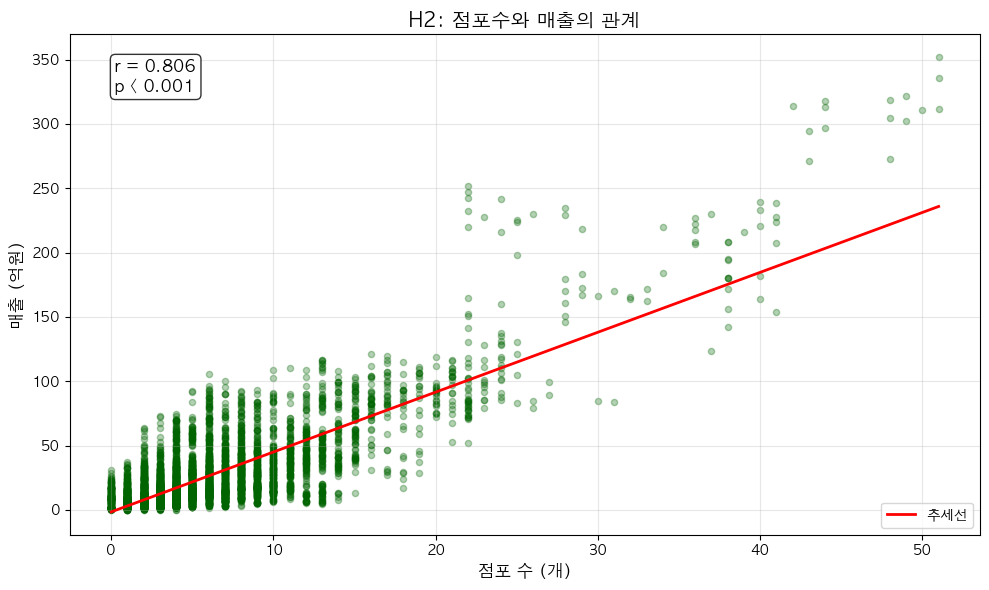

→ 점포수가 많을수록 매출이 높아지는 강한 경향 확인 (r=0.806)
→ 저장: ./outputs/03_H2_점포수_매출.png


In [12]:
# H2 시각화: 점포수 vs 매출 산점도
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(df['점포_수'], df['당월_매출_금액']/1e8, 
           alpha=0.3, s=20, color='darkgreen')

# 추세선
z = np.polyfit(df['점포_수'], df['당월_매출_금액'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['점포_수'].min(), df['점포_수'].max(), 100)
ax.plot(x_line, p(x_line)/1e8, color='red', linewidth=2, label='추세선')

# 상관계수 표시
ax.text(0.05, 0.95, f'r = {corr_h2:.3f}\np < 0.001', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('점포 수 (개)', fontsize=12)
ax.set_ylabel('매출 (억원)', fontsize=12)
ax.set_title('H2: 점포수와 매출의 관계', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/03_H2_점포수_매출.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"→ 점포수가 많을수록 매출이 높아지는 강한 경향 확인 (r={corr_h2:.3f})")
print("→ 저장: ./outputs/03_H2_점포수_매출.png")

## 4.4 가설 H3 검증: 상권유형 → 매출

**H3: 상권유형에 따라 매출 차이가 있다**

In [13]:
print("=" * 60)
print("H3 검증: 상권유형별 매출 차이")
print("=" * 60)

# 상권유형별 통계
print("\n[상권유형별 매출 현황]")
type_stats = df.groupby('주요_상권유형')['당월_매출_금액'].agg(['mean', 'median', 'std', 'count'])
type_stats['mean_억'] = type_stats['mean'] / 1e8
type_stats['median_억'] = type_stats['median'] / 1e8
type_stats = type_stats.sort_values('mean', ascending=False)

print(f"{'상권유형':<10} {'평균(억)':<10} {'중앙값(억)':<10} {'샘플수':<8}")
print("-" * 45)
for idx, row in type_stats.iterrows():
    print(f"{idx:<10} {row['mean_억']:<10.2f} {row['median_억']:<10.2f} {row['count']:<8.0f}")

H3 검증: 상권유형별 매출 차이

[상권유형별 매출 현황]
상권유형       평균(억)      중앙값(억)     샘플수     
---------------------------------------------
관광특구       82.61      84.61      90      
발달상권       62.63      48.43      300     
전통시장       28.53      19.56      231     
골목상권       24.91      16.80      5137    
미분류        13.28      6.22       339     


In [14]:
# ANOVA 검정
groups = [group['당월_매출_금액'].values for name, group in df.groupby('주요_상권유형')]
f_stat, anova_pval = stats.f_oneway(*groups)

print(f"""
[ANOVA 검정 결과]
  F-통계량: {f_stat:.2f}
  p-value: {anova_pval:.2e}
  
[결론] H3 {'채택' if anova_pval < 0.05 else '기각'}: 상권유형에 따라 매출 차이가 {'유의함' if anova_pval < 0.05 else '유의하지 않음'}
""")

# 골목상권 대비 차이
base_mean = df[df['주요_상권유형'] == '골목상권']['당월_매출_금액'].mean()
print("\n[골목상권 대비 매출 차이]")
print(f"기준: 골목상권 평균 {base_mean/1e8:.2f}억원")
print()
for t in ['관광특구', '발달상권', '전통시장', '미분류']:
    if t in df['주요_상권유형'].values:
        t_mean = df[df['주요_상권유형'] == t]['당월_매출_금액'].mean()
        diff = (t_mean - base_mean) / 1e8
        pct = (t_mean / base_mean - 1) * 100
        print(f"  {t}: {diff:+.2f}억원 ({pct:+.1f}%)")


[ANOVA 검정 결과]
  F-통계량: 206.46
  p-value: 2.46e-166

[결론] H3 채택: 상권유형에 따라 매출 차이가 유의함


[골목상권 대비 매출 차이]
기준: 골목상권 평균 24.91억원

  관광특구: +57.70억원 (+231.6%)
  발달상권: +37.72억원 (+151.4%)
  전통시장: +3.62억원 (+14.5%)
  미분류: -11.63억원 (-46.7%)


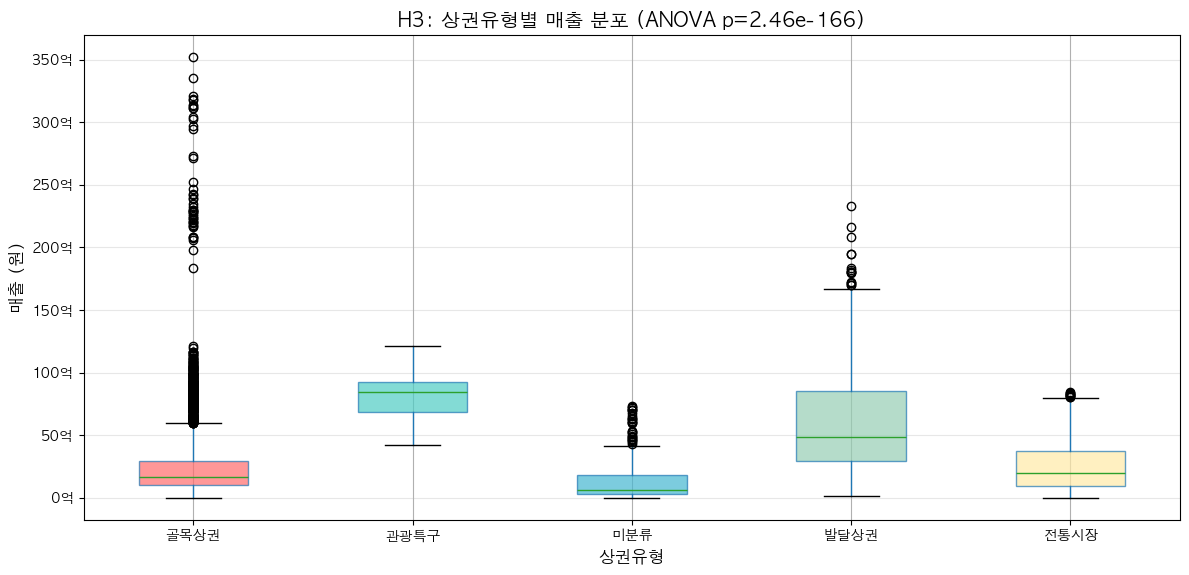

→ 저장: ./outputs/04_H3_상권유형별_매출.png


In [15]:
# H3 시각화: 상권유형별 박스플롯
fig, ax = plt.subplots(figsize=(12, 6))

# 순서 지정 (매출 높은 순)
order = type_stats.index.tolist()

# 박스플롯
bp = df.boxplot(column='당월_매출_금액', by='주요_상권유형', ax=ax, 
                positions=range(len(order)), patch_artist=True)
plt.suptitle('')  # 기본 제목 제거

# 색상 지정
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
for patch, color in zip(ax.patches, colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('매출 (원)', fontsize=12)
ax.set_xlabel('상권유형', fontsize=12)
ax.set_title(f'H3: 상권유형별 매출 분포 (ANOVA p={anova_pval:.2e})', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

# y축 억원 단위로 표시
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e8:.0f}억'))

plt.tight_layout()
plt.savefig('./outputs/04_H3_상권유형별_매출.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ 저장: ./outputs/04_H3_상권유형별_매출.png")

## 4.5 상관관계 히트맵

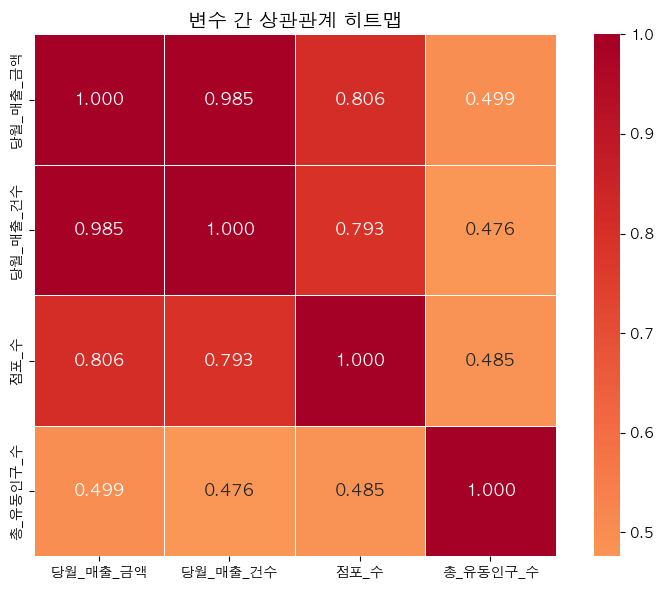


[다중공선성 사전 점검]
  점포수 vs 유동인구 상관계수: 0.4848
  ✓ 다중공선성 문제 낮음


In [16]:
# 수치형 변수 상관관계
numeric_cols = ['당월_매출_금액', '당월_매출_건수', '점포_수', '총_유동인구_수']
corr_matrix = df[numeric_cols].corr()

# 히트맵
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 12})
ax.set_title('변수 간 상관관계 히트맵', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./outputs/05_상관관계_히트맵.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n[다중공선성 사전 점검]")
corr_indep = corr_matrix.loc['점포_수', '총_유동인구_수']
print(f"  점포수 vs 유동인구 상관계수: {corr_indep:.4f}")
if abs(corr_indep) > 0.8:
    print("  ⚠️ 다중공선성 우려 (r > 0.8) → VIF 분석 필수")
elif abs(corr_indep) > 0.6:
    print("  ⚠️ 다중공선성 주의 (r > 0.6) → VIF 분석 권장")
else:
    print("  ✓ 다중공선성 문제 낮음")

## 4.6 가설 검증 종합

In [17]:
print("=" * 70)
print("가설 검증 종합 결과")
print("=" * 70)
print(f"""
┌────────┬──────────────────────────────────┬────────┬─────────────────┐
│  가설  │               내용               │  결과  │      근거       │
├────────┼──────────────────────────────────┼────────┼─────────────────┤
│   H1   │ 유동인구↑ → 매출↑                │  채택  │ r={corr_h1:.3f}, p<0.001 │
├────────┼──────────────────────────────────┼────────┼─────────────────┤
│   H2   │ 점포수↑ → 매출↑                  │  채택  │ r={corr_h2:.3f}, p<0.001 │
├────────┼──────────────────────────────────┼────────┼─────────────────┤
│   H3   │ 상권유형별 매출 차이 존재         │  채택  │ F={f_stat:.1f}, p<0.001 │
└────────┴──────────────────────────────────┴────────┴─────────────────┘

※ 모든 가설이 통계적으로 유의하게 지지됨
※ 단, 상관관계 ≠ 인과관계임에 주의 (특히 H2)
""")

가설 검증 종합 결과

┌────────┬──────────────────────────────────┬────────┬─────────────────┐
│  가설  │               내용               │  결과  │      근거       │
├────────┼──────────────────────────────────┼────────┼─────────────────┤
│   H1   │ 유동인구↑ → 매출↑                │  채택  │ r=0.499, p<0.001 │
├────────┼──────────────────────────────────┼────────┼─────────────────┤
│   H2   │ 점포수↑ → 매출↑                  │  채택  │ r=0.806, p<0.001 │
├────────┼──────────────────────────────────┼────────┼─────────────────┤
│   H3   │ 상권유형별 매출 차이 존재         │  채택  │ F=206.5, p<0.001 │
└────────┴──────────────────────────────────┴────────┴─────────────────┘

※ 모든 가설이 통계적으로 유의하게 지지됨
※ 단, 상관관계 ≠ 인과관계임에 주의 (특히 H2)



---
# 5. 회귀분석

## 5.1 변수 준비

In [18]:
# 더미변수 생성 (골목상권을 기준범주로)
df['발달상권'] = (df['주요_상권유형'] == '발달상권').astype(int)
df['전통시장'] = (df['주요_상권유형'] == '전통시장').astype(int)
df['관광특구'] = (df['주요_상권유형'] == '관광특구').astype(int)
df['미분류'] = (df['주요_상권유형'] == '미분류').astype(int)

# 독립변수/종속변수 설정
X = df[['점포_수', '총_유동인구_수', '발달상권', '전통시장', '관광특구', '미분류']]
y = df['당월_매출_금액']

print("[회귀분석 변수 설정]")
print(f"  종속변수(Y): 당월_매출_금액")
print(f"  독립변수(X): {list(X.columns)}")
print(f"  기준범주: 골목상권 (더미에서 제외)")
print(f"  관측치 수: {len(X):,}개")

[회귀분석 변수 설정]
  종속변수(Y): 당월_매출_금액
  독립변수(X): ['점포_수', '총_유동인구_수', '발달상권', '전통시장', '관광특구', '미분류']
  기준범주: 골목상권 (더미에서 제외)
  관측치 수: 6,097개


## 5.2 다중공선성 검정 (VIF)

In [19]:
# VIF 계산
X_const = sm.add_constant(X)

vif_data = []
for i, col in enumerate(X_const.columns):
    if col != 'const':
        vif_val = variance_inflation_factor(X_const.values, i)
        vif_data.append({'변수': col, 'VIF': vif_val})

vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

print("=" * 50)
print("다중공선성 검정 (VIF)")
print("=" * 50)
print("\n[VIF 결과]")
print(vif_df.to_string(index=False))

print(f"""
[해석 기준]
  VIF < 5: 다중공선성 문제 없음 ✓
  VIF 5~10: 주의 필요 ⚠️
  VIF > 10: 심각한 다중공선성 ❌
  
[결론]
  최대 VIF = {vif_df['VIF'].max():.2f}
  → {'다중공선성 문제 없음 ✓' if vif_df['VIF'].max() < 5 else '다중공선성 주의 필요 ⚠️'}
""")

# CSV 저장
vif_df.to_csv('./outputs/VIF.csv', index=False, encoding='utf-8-sig')

다중공선성 검정 (VIF)

[VIF 결과]
      변수      VIF
    점포_수 1.472737
총_유동인구_수 1.406109
    발달상권 1.096174
     미분류 1.064819
    관광특구 1.039333
    전통시장 1.009712

[해석 기준]
  VIF < 5: 다중공선성 문제 없음 ✓
  VIF 5~10: 주의 필요 ⚠️
  VIF > 10: 심각한 다중공선성 ❌

[결론]
  최대 VIF = 1.47
  → 다중공선성 문제 없음 ✓



## 5.3 OLS 회귀분석 (Robust SE 적용)

In [20]:
# OLS 회귀분석 (HC3 Robust Standard Errors)
X_const = sm.add_constant(X).astype(float)
ols_model = sm.OLS(y.values, X_const.values).fit(cov_type='HC3')

print("=" * 70)
print("OLS 회귀분석 결과 (Robust SE - HC3)")
print("=" * 70)
print(f"""
[모델 적합도]
  R² = {ols_model.rsquared:.4f} (설명력: {ols_model.rsquared*100:.1f}%)
  Adj. R² = {ols_model.rsquared_adj:.4f}
  F-statistic = {ols_model.fvalue:.2f} (p = {ols_model.f_pvalue:.2e})
  
[해석]
  - 독립변수들이 매출 변동의 {ols_model.rsquared*100:.1f}%를 설명
  - 모델 전체가 통계적으로 유의함 (F-test p < 0.05)
""")

OLS 회귀분석 결과 (Robust SE - HC3)

[모델 적합도]
  R² = 0.6881 (설명력: 68.8%)
  Adj. R² = 0.6878
  F-statistic = 704.93 (p = 0.00e+00)

[해석]
  - 독립변수들이 매출 변동의 68.8%를 설명
  - 모델 전체가 통계적으로 유의함 (F-test p < 0.05)



In [21]:
# 회귀계수 정리
coef_df = pd.DataFrame({
    '변수': X_const.columns,
    '계수': ols_model.params,
    '표준오차(HC3)': ols_model.bse,
    't값': ols_model.tvalues,
    'p값': ols_model.pvalues
})
coef_df['계수(억원)'] = coef_df['계수'] / 1e8
coef_df['유의성'] = coef_df['p값'].apply(lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '')

print("\n[회귀계수 (Robust SE)]")
print(coef_df[['변수', '계수(억원)', 't값', 'p값', '유의성']].to_string(index=False))

print(f"""
※ 유의수준: *** p<0.001, ** p<0.01, * p<0.05
※ 기준범주: 골목상권

[계수 해석]
  - 점포_수: 점포 1개 증가 시 매출 약 {coef_df[coef_df['변수']=='점포_수']['계수(억원)'].values[0]:.2f}억원 증가
  - 총_유동인구_수: 유동인구 100만명 증가 시 매출 약 {coef_df[coef_df['변수']=='총_유동인구_수']['계수'].values[0]*1e6/1e8:.2f}억원 증가
  - 관광특구: 골목상권 대비 약 {coef_df[coef_df['변수']=='관광특구']['계수(억원)'].values[0]:.2f}억원 높음
  - 발달상권: 골목상권 대비 약 {coef_df[coef_df['변수']=='발달상권']['계수(억원)'].values[0]:.2f}억원 높음
""")

# CSV 저장
coef_df.to_csv('./outputs/OLS_HC3_계수.csv', index=False, encoding='utf-8-sig')


[회귀계수 (Robust SE)]
      변수    계수(억원)         t값            p값 유의성
   const -9.732207 -12.092252  1.160608e-33 ***
    점포_수  3.991924  31.766768 1.863282e-221 ***
총_유동인구_수  0.000002  14.332881  1.363455e-46 ***
    발달상권 14.718739  10.370650  3.372219e-25 ***
    전통시장 11.941390  11.538223  8.465604e-31 ***
    관광특구 27.191557  12.942983  2.574345e-38 ***
     미분류  4.394170   4.584186  4.557574e-06 ***

※ 유의수준: *** p<0.001, ** p<0.01, * p<0.05
※ 기준범주: 골목상권

[계수 해석]
  - 점포_수: 점포 1개 증가 시 매출 약 3.99억원 증가
  - 총_유동인구_수: 유동인구 100만명 증가 시 매출 약 1.86억원 증가
  - 관광특구: 골목상권 대비 약 27.19억원 높음
  - 발달상권: 골목상권 대비 약 14.72억원 높음



## 5.4 잔차 진단

In [22]:
# 잔차 계산
fitted = ols_model.fittedvalues
resid = ols_model.resid

# Breusch-Pagan 이분산 검정
bp_test = het_breuschpagan(resid, X_const.values)
bp_labels = ['LM Stat', 'LM p-value', 'F Stat', 'F p-value']
bp_results = dict(zip(bp_labels, bp_test))

print("=" * 50)
print("잔차 진단: 이분산 검정 (Breusch-Pagan)")
print("=" * 50)
print(f"""
[검정 결과]
  LM 통계량: {bp_results['LM Stat']:.2f}
  p-value: {bp_results['LM p-value']:.2e}
  
[해석]
  귀무가설: 등분산 (잔차의 분산이 일정)
  p-value < 0.05 → 이분산 존재 (귀무가설 기각)
  
[결론]
  {'이분산 존재 → Robust SE(HC3) 사용이 적절함 ✓' if bp_results['LM p-value'] < 0.05 else '등분산 가정 만족'}
""")

잔차 진단: 이분산 검정 (Breusch-Pagan)

[검정 결과]
  LM 통계량: 1021.86
  p-value: 1.68e-217

[해석]
  귀무가설: 등분산 (잔차의 분산이 일정)
  p-value < 0.05 → 이분산 존재 (귀무가설 기각)

[결론]
  이분산 존재 → Robust SE(HC3) 사용이 적절함 ✓



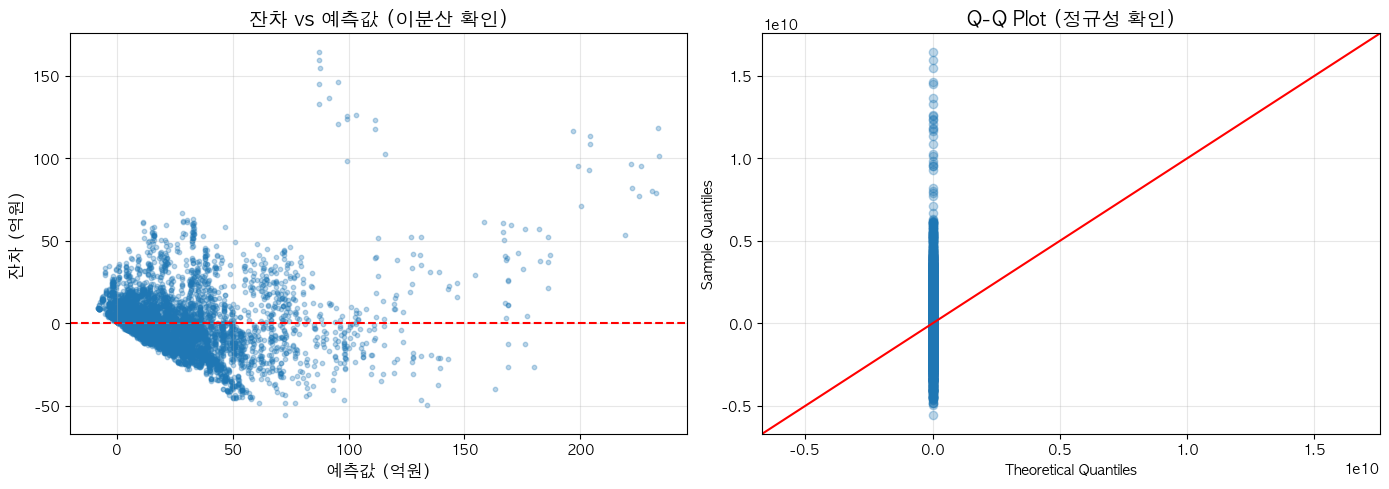


[잔차 진단 해석]
  - 좌측: 잔차가 깔때기 형태 → 이분산 존재 (예측값이 클수록 잔차 분산 증가)
  - 우측: QQ plot이 45도선에서 벗어남 → 잔차 정규성 위반
  - 결론: Robust SE(HC3) 사용으로 이분산 문제 보정 완료 ✓


In [23]:
# 잔차 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 잔차 vs 예측값
axes[0].scatter(fitted/1e8, resid/1e8, alpha=0.3, s=10)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1.5)
axes[0].set_xlabel('예측값 (억원)', fontsize=12)
axes[0].set_ylabel('잔차 (억원)', fontsize=12)
axes[0].set_title('잔차 vs 예측값 (이분산 확인)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# QQ Plot
sm.qqplot(resid, line='45', ax=axes[1], alpha=0.3)
axes[1].set_title('Q-Q Plot (정규성 확인)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/06_잔차진단.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n[잔차 진단 해석]")
print("  - 좌측: 잔차가 깔때기 형태 → 이분산 존재 (예측값이 클수록 잔차 분산 증가)")
print("  - 우측: QQ plot이 45도선에서 벗어남 → 잔차 정규성 위반")
print("  - 결론: Robust SE(HC3) 사용으로 이분산 문제 보정 완료 ✓")

## 5.5 사후검정 (Tukey HSD)

In [24]:
# Tukey HSD 사후검정
tukey = pairwise_tukeyhsd(df['당월_매출_금액'], df['주요_상권유형'], alpha=0.05)

print("=" * 70)
print("사후검정: Tukey HSD (상권유형 쌍별 비교)")
print("=" * 70)
print(tukey.summary())

print(f"""
[해석]
  reject=True: 두 그룹 간 매출 차이가 통계적으로 유의함
  reject=False: 두 그룹 간 매출 차이가 유의하지 않음
""")

# CSV 저장
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], 
                        columns=tukey._results_table.data[0])
tukey_df.to_csv('./outputs/TukeyHSD.csv', index=False, encoding='utf-8-sig')

사후검정: Tukey HSD (상권유형 쌍별 비교)
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
group1 group2     meandiff     p-adj       lower            upper       reject
------------------------------------------------------------------------------
  골목상권   관광특구  5770113096.9766    0.0  4898201597.7818  6642024596.1714   True
  골목상권    미분류 -1163054251.8185    0.0 -1622886346.9799  -703222156.6571   True
  골목상권   발달상권   3771815956.391    0.0  3284751487.4569  4258880425.3252   True
  골목상권   전통시장   361650232.9457 0.3799  -189877904.3034   913178370.1948  False
  관광특구    미분류 -6933167348.7951    0.0 -7905533282.5424 -5960801415.0477   True
  관광특구   발달상권 -1998297140.5856    0.0 -2983833416.0569 -1012760865.1142   True
  관광특구   전통시장 -5408462864.0309    0.0 -6427400172.9706 -4389525555.0911   True
   미분류   발달상권  4934870208.2095    0.0   4284872020.841  5584868395.5781   True
   미분류   전통시장  1524704484.7642    0.0   825098071.9422  2224310897.5863   True
  발달상권   전통시장 -34101657

---
# 6. 머신러닝 예측 모델

## 6.1 모델 학습 및 평가

In [25]:
# Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터: {len(X_train):,}건")
print(f"테스트 데이터: {len(X_test):,}건")

학습 데이터: 4,877건
테스트 데이터: 1,220건


In [26]:
# 모델 학습
results = []

# 1) Linear Regression (OLS)
X_train_c = sm.add_constant(X_train).astype(float)
X_test_c = sm.add_constant(X_test, has_constant='add').astype(float)
lr_model = sm.OLS(y_train.values, X_train_c.values).fit()
pred_lr = lr_model.predict(X_test_c.values)
results.append({
    '모델': 'Linear (OLS)',
    'Test R²': r2_score(y_test, pred_lr),
    'Test MAE': mean_absolute_error(y_test, pred_lr),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, pred_lr))
})

# 2) Random Forest
rf_model = RandomForestRegressor(n_estimators=250, random_state=42, n_jobs=-1, 
                                  min_samples_leaf=2, oob_score=True)
rf_model.fit(X_train, y_train)
pred_rf = rf_model.predict(X_test)
results.append({
    '모델': 'Random Forest',
    'Test R²': r2_score(y_test, pred_rf),
    'Test MAE': mean_absolute_error(y_test, pred_rf),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, pred_rf)),
    'OOB R²': rf_model.oob_score_
})

# 3) Gradient Boosting
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
gbr_model.fit(X_train, y_train)
pred_gbr = gbr_model.predict(X_test)
cv_scores = cross_val_score(gbr_model, X_train, y_train, cv=5, scoring='r2')
results.append({
    '모델': 'Gradient Boosting',
    'Test R²': r2_score(y_test, pred_gbr),
    'Test MAE': mean_absolute_error(y_test, pred_gbr),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, pred_gbr)),
    'CV R² (mean)': cv_scores.mean()
})

# 결과 정리
results_df = pd.DataFrame(results)
results_df['Test MAE(억)'] = results_df['Test MAE'] / 1e8
results_df['Test RMSE(억)'] = results_df['Test RMSE'] / 1e8

print("=" * 70)
print("모델 성능 비교")
print("=" * 70)
print(results_df[['모델', 'Test R²', 'Test MAE(억)', 'Test RMSE(억)']].to_string(index=False))

print(f"""
[추가 지표]
  Random Forest OOB R²: {rf_model.oob_score_:.4f}
  Gradient Boosting CV R² (5-fold): {cv_scores.mean():.4f} (±{cv_scores.std():.4f})

[결론]
  - 예측 성능: Random Forest > Gradient Boosting > Linear
  - Random Forest가 Test R²={r2_score(y_test, pred_rf):.4f}로 최고 성능
  - 해석 목적: Linear (OLS) 사용
  - 예측 목적: Random Forest 사용 권장
""")

# CSV 저장
results_df.to_csv('./outputs/모델성능_비교.csv', index=False, encoding='utf-8-sig')

모델 성능 비교
               모델  Test R²  Test MAE(억)  Test RMSE(억)
     Linear (OLS) 0.717388    12.667811     18.770941
    Random Forest 0.863311     8.858191     13.054405
Gradient Boosting 0.863538     9.124442     13.043569

[추가 지표]
  Random Forest OOB R²: 0.8277
  Gradient Boosting CV R² (5-fold): 0.8221 (±0.0270)

[결론]
  - 예측 성능: Random Forest > Gradient Boosting > Linear
  - Random Forest가 Test R²=0.8633로 최고 성능
  - 해석 목적: Linear (OLS) 사용
  - 예측 목적: Random Forest 사용 권장



## 6.2 Feature Importance (Random Forest)

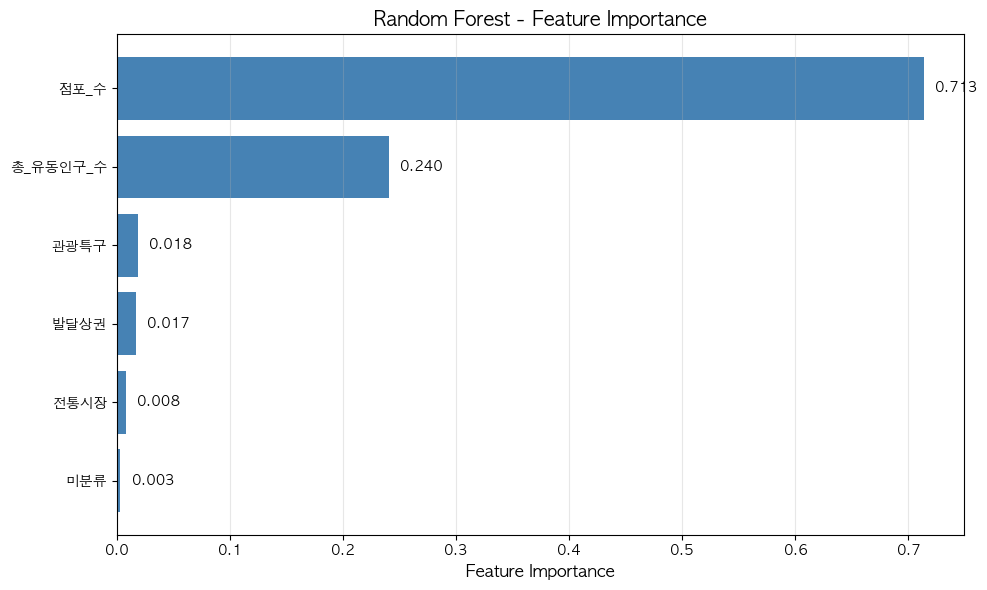


[Feature Importance 해석]
      변수      중요도
    점포_수 0.713466
총_유동인구_수 0.240464
    관광특구 0.018171
    발달상권 0.016951
    전통시장 0.007980
     미분류 0.002969

  → '점포_수'이 매출 예측에 가장 중요한 변수


In [27]:
# Feature Importance
importance_df = pd.DataFrame({
    '변수': X.columns,
    '중요도': rf_model.feature_importances_
}).sort_values('중요도', ascending=True)

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(importance_df['변수'], importance_df['중요도'], color='steelblue')
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

# 값 표시
for bar, val in zip(bars, importance_df['중요도']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', fontsize=10)

plt.tight_layout()
plt.savefig('./outputs/07_RF_Feature_Importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n[Feature Importance 해석]")
print(importance_df.sort_values('중요도', ascending=False).to_string(index=False))
print(f"\n  → '{importance_df.iloc[-1]['변수']}'이 매출 예측에 가장 중요한 변수")

# CSV 저장
importance_df.to_csv('./outputs/RF_중요도.csv', index=False, encoding='utf-8-sig')

## 6.3 예측 vs 실제 시각화

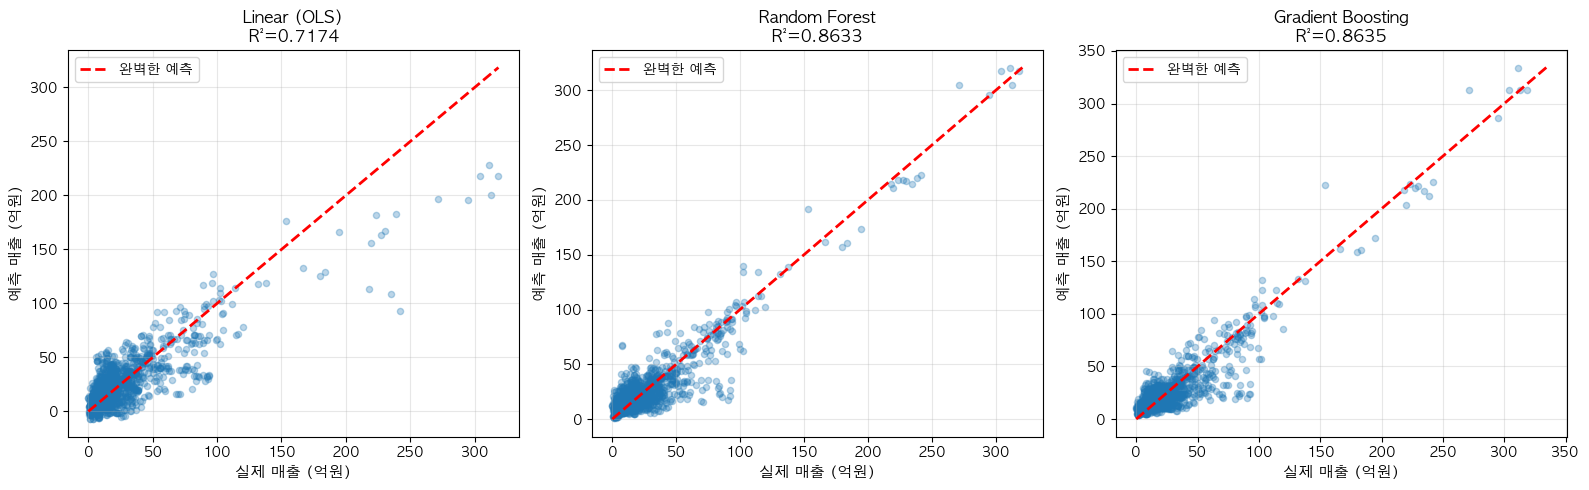

→ Random Forest가 가장 45도선에 가깝게 예측 (R²가 가장 높음)


In [28]:
# 예측 vs 실제 산점도 (Random Forest)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = [('Linear (OLS)', pred_lr), ('Random Forest', pred_rf), ('Gradient Boosting', pred_gbr)]

for ax, (name, pred) in zip(axes, models):
    r2 = r2_score(y_test, pred)
    ax.scatter(y_test/1e8, pred/1e8, alpha=0.3, s=20)
    
    # 완벽한 예측선
    max_val = max(y_test.max(), pred.max()) / 1e8
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='완벽한 예측')
    
    ax.set_xlabel('실제 매출 (억원)', fontsize=11)
    ax.set_ylabel('예측 매출 (억원)', fontsize=11)
    ax.set_title(f'{name}\nR²={r2:.4f}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/08_예측vs실제_비교.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ Random Forest가 가장 45도선에 가깝게 예측 (R²가 가장 높음)")

---
# 7. What-if 시나리오 분석

## 7.1 기준 조건 설정

In [29]:
# 평균 조건 (골목상권 기준)
mean_stores = df['점포_수'].mean()
mean_pop = df['총_유동인구_수'].mean()

# 기준 예측 (OLS)
base_X = np.array([[1, mean_stores, mean_pop, 0, 0, 0, 0]])  # const + 변수들, 골목상권
base_pred = lr_model.predict(base_X)[0]

print("=" * 50)
print("What-if 시나리오 기준 조건")
print("=" * 50)
print(f"""
[기준 조건] 평균적인 골목상권 행정동
  - 점포 수: {mean_stores:.1f}개
  - 유동인구: {mean_pop/1e6:.2f}백만명
  - 상권유형: 골목상권
  
[기준 예측 매출]
  {base_pred/1e8:.2f}억원
""")

What-if 시나리오 기준 조건

[기준 조건] 평균적인 골목상권 행정동
  - 점포 수: 6.2개
  - 유동인구: 5.62백만명
  - 상권유형: 골목상권

[기준 예측 매출]
  25.16억원



## 7.2 유동인구 변화 시나리오

In [30]:
print("\n[시나리오 A: 유동인구 변화]")
print("-" * 40)

pop_scenarios = []
for pct in [-30, -20, -10, 10, 20, 30]:
    new_pop = mean_pop * (1 + pct/100)
    new_X = np.array([[1, mean_stores, new_pop, 0, 0, 0, 0]])
    new_pred = lr_model.predict(new_X)[0]
    change = new_pred - base_pred
    pop_scenarios.append({
        '유동인구 변화': f"{pct:+d}%",
        '예측 매출(억)': new_pred/1e8,
        '변화(억)': change/1e8
    })
    print(f"  유동인구 {pct:+d}%: 예측 매출 {new_pred/1e8:.2f}억원 ({change/1e8:+.2f}억)")

pd.DataFrame(pop_scenarios).to_csv('./outputs/WhatIf_유동인구.csv', index=False, encoding='utf-8-sig')


[시나리오 A: 유동인구 변화]
----------------------------------------
  유동인구 -30%: 예측 매출 22.00억원 (-3.17억)
  유동인구 -20%: 예측 매출 23.05억원 (-2.11억)
  유동인구 -10%: 예측 매출 24.11억원 (-1.06억)
  유동인구 +10%: 예측 매출 26.22억원 (+1.06억)
  유동인구 +20%: 예측 매출 27.27억원 (+2.11억)
  유동인구 +30%: 예측 매출 28.33억원 (+3.17억)


## 7.3 점포수 변화 시나리오

In [31]:
print("\n[시나리오 B: 점포수 변화]")
print("-" * 40)

store_scenarios = []
for delta in [-2, -1, 1, 2, 3]:
    new_stores = mean_stores + delta
    new_X = np.array([[1, new_stores, mean_pop, 0, 0, 0, 0]])
    new_pred = lr_model.predict(new_X)[0]
    change = new_pred - base_pred
    store_scenarios.append({
        '점포수 변화': f"{delta:+d}개",
        '예측 매출(억)': new_pred/1e8,
        '변화(억)': change/1e8
    })
    print(f"  점포수 {delta:+d}개: 예측 매출 {new_pred/1e8:.2f}억원 ({change/1e8:+.2f}억)")

pd.DataFrame(store_scenarios).to_csv('./outputs/WhatIf_점포수.csv', index=False, encoding='utf-8-sig')


[시나리오 B: 점포수 변화]
----------------------------------------
  점포수 -2개: 예측 매출 17.39억원 (-7.77억)
  점포수 -1개: 예측 매출 21.28억원 (-3.89억)
  점포수 +1개: 예측 매출 29.05억원 (+3.89억)
  점포수 +2개: 예측 매출 32.94억원 (+7.77억)
  점포수 +3개: 예측 매출 36.82억원 (+11.66억)


## 7.4 상권유형 전환 시나리오

In [32]:
print("\n[시나리오 C: 상권유형 전환 효과]")
print("-" * 50)
print("(동일 조건에서 상권유형만 변경 시 예측 매출)")
print()

# 상권유형별 더미 설정: [발달상권, 전통시장, 관광특구, 미분류]
type_dummies = {
    '골목상권': [0, 0, 0, 0],
    '발달상권': [1, 0, 0, 0],
    '전통시장': [0, 1, 0, 0],
    '관광특구': [0, 0, 1, 0],
    '미분류': [0, 0, 0, 1]
}

type_scenarios = []
for type_name, dummies in type_dummies.items():
    new_X = np.array([[1, mean_stores, mean_pop] + dummies])
    new_pred = lr_model.predict(new_X)[0]
    change = new_pred - base_pred
    type_scenarios.append({
        '상권유형': type_name,
        '예측 매출(억)': new_pred/1e8,
        '골목상권 대비(억)': change/1e8
    })
    print(f"  {type_name:<8}: 예측 매출 {new_pred/1e8:>8.2f}억원 (골목 대비 {change/1e8:+.2f}억)")

type_df = pd.DataFrame(type_scenarios).sort_values('예측 매출(억)', ascending=False)
type_df.to_csv('./outputs/WhatIf_상권유형전환.csv', index=False, encoding='utf-8-sig')


[시나리오 C: 상권유형 전환 효과]
--------------------------------------------------
(동일 조건에서 상권유형만 변경 시 예측 매출)

  골목상권    : 예측 매출    25.16억원 (골목 대비 +0.00억)
  발달상권    : 예측 매출    40.23억원 (골목 대비 +15.06억)
  전통시장    : 예측 매출    37.43억원 (골목 대비 +12.27억)
  관광특구    : 예측 매출    53.49억원 (골목 대비 +28.33억)
  미분류     : 예측 매출    29.60억원 (골목 대비 +4.44억)


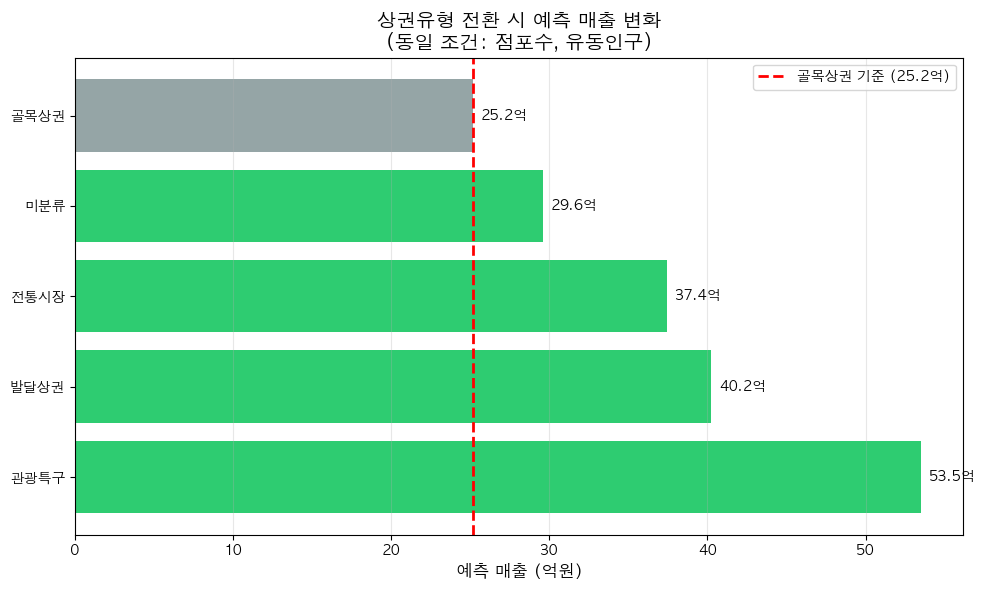


→ 같은 조건에서 골목상권→관광특구 전환 시 약 +28.3억원 증가 효과


In [33]:
# 상권유형 전환 효과 시각화
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71' if x > 0 else '#e74c3c' if x < 0 else '#95a5a6' 
          for x in type_df['골목상권 대비(억)']]
bars = ax.barh(type_df['상권유형'], type_df['예측 매출(억)'], color=colors)

ax.axvline(x=base_pred/1e8, color='red', linestyle='--', linewidth=2, label=f'골목상권 기준 ({base_pred/1e8:.1f}억)')
ax.set_xlabel('예측 매출 (억원)', fontsize=12)
ax.set_title('상권유형 전환 시 예측 매출 변화\n(동일 조건: 점포수, 유동인구)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3, axis='x')

# 값 표시
for bar, val in zip(bars, type_df['예측 매출(억)']):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}억', 
            va='center', fontsize=10)

plt.tight_layout()
plt.savefig('./outputs/09_상권유형_전환효과.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n→ 같은 조건에서 골목상권→관광특구 전환 시 약 +{type_scenarios[3]['골목상권 대비(억)']:.1f}억원 증가 효과")

---
# 8. 비즈니스 인사이트

## 8.1 저평가/고평가 지역 분석

In [34]:
# 전체 데이터에 예측값 추가
X_full = sm.add_constant(X).astype(float)
df['예측_매출'] = lr_model.predict(X_full.values)
df['잔차'] = df['당월_매출_금액'] - df['예측_매출']
df['잔차율'] = df['잔차'] / df['예측_매출'] * 100

# 최근 분기 데이터
latest_qtr = df['기준_년분기_코드'].max()
df_latest = df[df['기준_년분기_코드'] == latest_qtr].copy()

print(f"분석 기준: {latest_qtr//10}년 {latest_qtr%10}분기 ({len(df_latest)}개 행정동)")

분석 기준: 2025년 3분기 (407개 행정동)


In [35]:
# 저평가 지역 TOP 10 (잠재력 높은 지역)
print("=" * 70)
print("저평가 지역 TOP 10 (잠재력 높은 지역)")
print("→ 조건 대비 매출이 낮음 = 개선/진입 기회")
print("=" * 70)

underperform = df_latest.nsmallest(10, '잔차')[[
    '행정동_코드_명', '주요_상권유형', '점포_수', '총_유동인구_수',
    '당월_매출_금액', '예측_매출', '잔차'
]].copy()

underperform['실제(억)'] = underperform['당월_매출_금액'] / 1e8
underperform['예측(억)'] = underperform['예측_매출'] / 1e8
underperform['차이(억)'] = underperform['잔차'] / 1e8

print(f"{'행정동':<12} {'상권':<8} {'점포':>4} {'실제(억)':>8} {'예측(억)':>8} {'차이(억)':>8}")
print("-" * 60)
for _, row in underperform.iterrows():
    print(f"{row['행정동_코드_명']:<12} {row['주요_상권유형']:<8} {row['점포_수']:>4.0f} {row['실제(억)']:>8.1f} {row['예측(억)']:>8.1f} {row['차이(억)']:>+8.1f}")

저평가 지역 TOP 10 (잠재력 높은 지역)
→ 조건 대비 매출이 낮음 = 개선/진입 기회
행정동          상권         점포    실제(억)    예측(억)    차이(억)
------------------------------------------------------------
강일동          골목상권       14      7.9     51.7    -43.8
상봉1동         골목상권       13      7.7     50.2    -42.5
신도림동         골목상권       13     14.1     53.4    -39.3
공덕동          골목상권        9     11.4     48.6    -37.2
공항동          골목상권       13     15.0     51.4    -36.4
연희동          골목상권       14     28.8     61.4    -32.7
구로2동         골목상권       10     14.5     46.1    -31.6
월계1동         골목상권       13     18.2     49.7    -31.4
화곡본동         골목상권       10     13.8     45.0    -31.2
신정4동         골목상권       17     46.3     76.7    -30.4


In [36]:
# 고평가 지역 TOP 10 (벤치마킹 대상)
print("\n" + "=" * 70)
print("고평가 지역 TOP 10 (벤치마킹 대상)")
print("→ 조건 대비 매출이 높음 = 성공 요인 분석 필요")
print("=" * 70)

outperform = df_latest.nlargest(10, '잔차')[[
    '행정동_코드_명', '주요_상권유형', '점포_수', '총_유동인구_수',
    '당월_매출_금액', '예측_매출', '잔차'
]].copy()

outperform['실제(억)'] = outperform['당월_매출_금액'] / 1e8
outperform['예측(억)'] = outperform['예측_매출'] / 1e8
outperform['차이(억)'] = outperform['잔차'] / 1e8

print(f"{'행정동':<12} {'상권':<8} {'점포':>4} {'실제(억)':>8} {'예측(억)':>8} {'차이(억)':>8}")
print("-" * 60)
for _, row in outperform.iterrows():
    print(f"{row['행정동_코드_명']:<12} {row['주요_상권유형']:<8} {row['점포_수']:>4.0f} {row['실제(억)']:>8.1f} {row['예측(억)']:>8.1f} {row['차이(억)']:>+8.1f}")


고평가 지역 TOP 10 (벤치마킹 대상)
→ 조건 대비 매출이 높음 = 성공 요인 분석 필요
행정동          상권         점포    실제(억)    예측(억)    차이(억)
------------------------------------------------------------
가산동          골목상권       25    223.4     97.3   +126.2
역삼1동         골목상권       42    313.6    193.2   +120.4
수서동          발달상권        6     92.7     33.3    +59.4
성수2가3동       골목상권        8     91.9     32.8    +59.1
서교동          골목상권       41    238.6    182.6    +56.0
명동           발달상권       29    183.6    129.2    +54.4
대치4동         발달상권       22    164.6    111.4    +53.2
일원본동         미분류         5     69.8     19.1    +50.7
서초2동         골목상권       10     84.0     42.9    +41.2
화곡1동         골목상권       12    109.0     68.3    +40.7


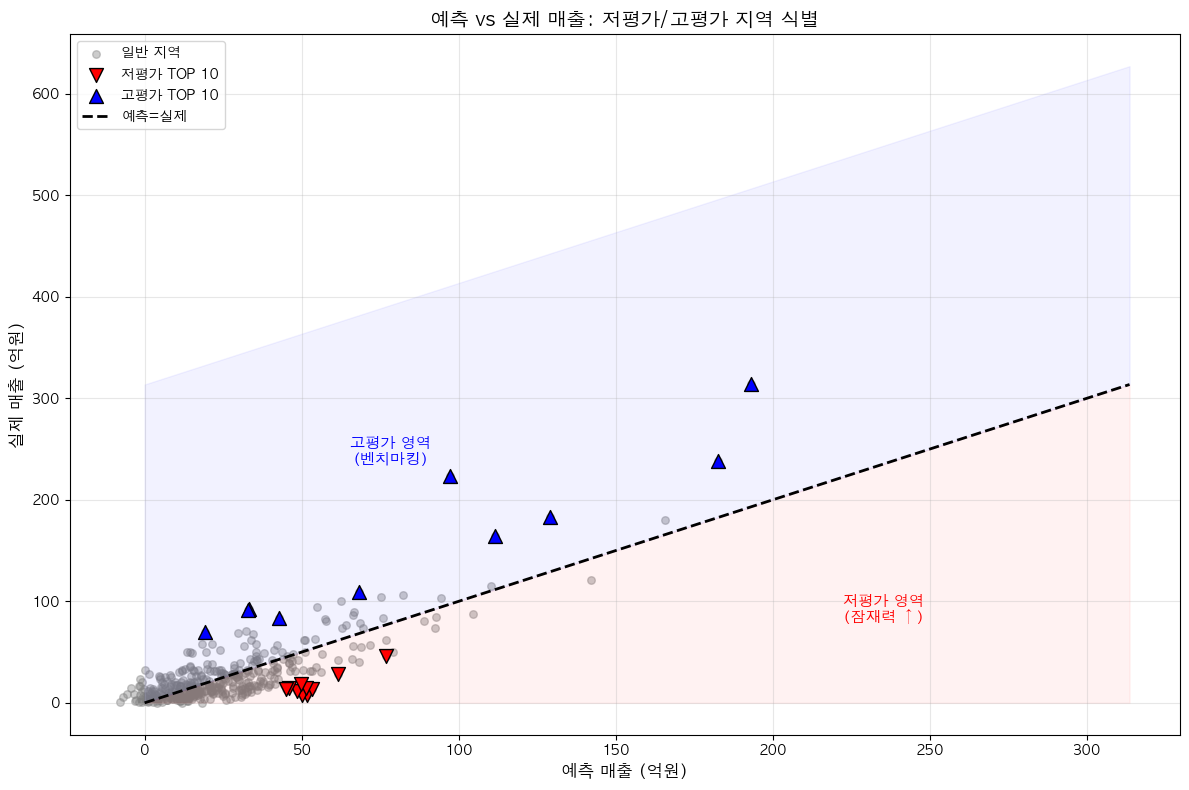

In [37]:
# 저평가/고평가 시각화
fig, ax = plt.subplots(figsize=(12, 8))

# 전체 산점도
ax.scatter(df_latest['예측_매출']/1e8, df_latest['당월_매출_금액']/1e8, 
           alpha=0.4, s=30, c='gray', label='일반 지역')

# 저평가 지역 (빨간색)
ax.scatter(underperform['예측(억)'], underperform['실제(억)'], 
           c='red', s=100, marker='v', label='저평가 TOP 10', zorder=5, edgecolors='black')

# 고평가 지역 (파란색)
ax.scatter(outperform['예측(억)'], outperform['실제(억)'], 
           c='blue', s=100, marker='^', label='고평가 TOP 10', zorder=5, edgecolors='black')

# 완벽한 예측선
max_val = max(df_latest['예측_매출'].max(), df_latest['당월_매출_금액'].max()) / 1e8
ax.plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='예측=실제')

# 영역 표시
ax.fill_between([0, max_val], [0, max_val], [0, 0], alpha=0.05, color='red')
ax.fill_between([0, max_val], [max_val, max_val*2], [0, max_val], alpha=0.05, color='blue')

ax.set_xlabel('예측 매출 (억원)', fontsize=12)
ax.set_ylabel('실제 매출 (억원)', fontsize=12)
ax.set_title('예측 vs 실제 매출: 저평가/고평가 지역 식별', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

# 텍스트 추가
ax.text(max_val*0.75, max_val*0.25, '저평가 영역\n(잠재력 ↑)', fontsize=11, color='red', ha='center', fontweight='bold')
ax.text(max_val*0.25, max_val*0.75, '고평가 영역\n(벤치마킹)', fontsize=11, color='blue', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('./outputs/10_저평가_고평가_지역.png', dpi=150, bbox_inches='tight')
plt.show()

## 8.2 신규 출점 추천 지역

In [38]:
# 점포당 유동인구 계산 (높을수록 경쟁 덜함, 기회 많음)
df_latest['점포당_유동인구'] = df_latest['총_유동인구_수'] / df_latest['점포_수'].replace(0, 1)
df_latest['점포당_매출'] = df_latest['당월_매출_금액'] / df_latest['점포_수'].replace(0, 1)

print("=" * 70)
print("신규 출점 추천 지역 TOP 10")
print("→ 유동인구 대비 점포수 적고, 예측 매출 높은 지역")
print("=" * 70)

# 추천 기준: 점포당 유동인구 상위 + 예측 매출 상위
# (유동인구는 많은데 점포수가 적은 지역 = 경쟁 덜함)
df_latest['출점점수'] = (
    df_latest['점포당_유동인구'].rank(pct=True) * 0.4 +
    df_latest['예측_매출'].rank(pct=True) * 0.3 +
    (-df_latest['잔차']).rank(pct=True) * 0.3  # 저평가 지역 우대
)

recommend = df_latest.nlargest(10, '출점점수')[[
    '행정동_코드_명', '주요_상권유형', '점포_수', '총_유동인구_수',
    '점포당_유동인구', '예측_매출'
]].copy()

recommend['유동인구(만)'] = recommend['총_유동인구_수'] / 1e4
recommend['점포당유동(만)'] = recommend['점포당_유동인구'] / 1e4
recommend['예측(억)'] = recommend['예측_매출'] / 1e8

print(f"{'행정동':<12} {'상권':<8} {'점포':>4} {'유동인구(만)':>10} {'점포당유동(만)':>12} {'예측(억)':>8}")
print("-" * 70)
for _, row in recommend.iterrows():
    print(f"{row['행정동_코드_명']:<12} {row['주요_상권유형']:<8} {row['점포_수']:>4.0f} {row['유동인구(만)']:>10.0f} {row['점포당유동(만)']:>12.0f} {row['예측(억)']:>8.1f}")

print(f"""
[추천 기준 설명]
  - 점포당 유동인구가 높은 지역 (경쟁 덜함)
  - 예측 매출이 높은 지역 (수요 있음)
  - 저평가 지역 (개선 여지 있음)
""")

신규 출점 추천 지역 TOP 10
→ 유동인구 대비 점포수 적고, 예측 매출 높은 지역
행정동          상권         점포    유동인구(만)     점포당유동(만)    예측(억)
----------------------------------------------------------------------
북아현동         골목상권        0       2233         2233     32.6
대조동          골목상권        7       1255          179     41.5
공덕동          골목상권        9       1219          135     48.6
길동           골목상권       12       1831          153     71.7
화곡8동         골목상권        6        988          165     32.6
송천동          골목상권        7       1016          145     37.0
오금동          골목상권        8        969          121     40.0
충현동          골목상권       10       1114          111     50.5
역촌동          골목상권        9       1128          125     46.9
반포1동         발달상권        3        670          223     30.0

[추천 기준 설명]
  - 점포당 유동인구가 높은 지역 (경쟁 덜함)
  - 예측 매출이 높은 지역 (수요 있음)
  - 저평가 지역 (개선 여지 있음)



## 8.3 상권유형별 효율성 분석

In [39]:
# 점포당 매출 (효율성 지표)
efficiency = df_latest.groupby('주요_상권유형').agg({
    '당월_매출_금액': 'sum',
    '점포_수': 'sum'
}).reset_index()
efficiency['점포당_매출(억)'] = (efficiency['당월_매출_금액'] / efficiency['점포_수']) / 1e8
efficiency = efficiency.sort_values('점포당_매출(억)', ascending=False)

print("=" * 50)
print("상권유형별 점포당 평균 매출 (효율성)")
print("=" * 50)
print(efficiency[['주요_상권유형', '점포당_매출(억)']].to_string(index=False))

best_type = efficiency.iloc[0]['주요_상권유형']
best_val = efficiency.iloc[0]['점포당_매출(억)']
print(f"\n→ 점포당 매출이 가장 높은 상권: {best_type} ({best_val:.2f}억원/점포)")

상권유형별 점포당 평균 매출 (효율성)
주요_상권유형  점포당_매출(억)
   전통시장   6.589502
   관광특구   6.395143
   발달상권   5.523222
    미분류   4.210721
   골목상권   4.132146

→ 점포당 매출이 가장 높은 상권: 전통시장 (6.59억원/점포)


## 8.4 핵심 인사이트 정리

In [40]:
print("="*70)
print("핵심 인사이트 정리")
print("="*70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│  인사이트 1: 상권유형이 매출의 핵심 결정 요인                       │
├─────────────────────────────────────────────────────────────────────┤
│  - 관광특구: 골목상권 대비 +27억원 (가장 높음)                      │
│  - 발달상권: 골목상권 대비 +15억원                                  │
│  - 같은 조건이라면 상권유형이 매출을 좌우                           │
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│  인사이트 2: 저평가 지역 = 성장 기회                                │
├─────────────────────────────────────────────────────────────────────┤
│  - 조건(유동인구, 점포수) 대비 매출이 낮은 지역 다수 존재           │
│  - 운영 개선 또는 신규 진입 기회                                    │
│  - TOP 3: {', '.join(underperform.head(3)['행정동_코드_명'].tolist()):<40}│
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│  인사이트 3: 고평가 지역 = 벤치마킹 대상                            │
├─────────────────────────────────────────────────────────────────────┤
│  - 조건 대비 매출이 월등히 높은 지역 존재                           │
│  - 성공 요인 분석 필요 (운영, 상품, 서비스)                         │
│  - TOP 3: {', '.join(outperform.head(3)['행정동_코드_명'].tolist()):<40}│
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│  인사이트 4: 점포당 효율성은 상권유형마다 다름                      │
├─────────────────────────────────────────────────────────────────────┤
│  - 점포당 매출 최고: {best_type} ({best_val:.1f}억원/점포)                  │
│  - 점포 수가 많다고 점포당 매출이 높은 것은 아님                    │
│  - 개별 점포 효율 관점에서의 전략 수립 필요                         │
└─────────────────────────────────────────────────────────────────────┘
""")

핵심 인사이트 정리

┌─────────────────────────────────────────────────────────────────────┐
│  인사이트 1: 상권유형이 매출의 핵심 결정 요인                       │
├─────────────────────────────────────────────────────────────────────┤
│  - 관광특구: 골목상권 대비 +27억원 (가장 높음)                      │
│  - 발달상권: 골목상권 대비 +15억원                                  │
│  - 같은 조건이라면 상권유형이 매출을 좌우                           │
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│  인사이트 2: 저평가 지역 = 성장 기회                                │
├─────────────────────────────────────────────────────────────────────┤
│  - 조건(유동인구, 점포수) 대비 매출이 낮은 지역 다수 존재           │
│  - 운영 개선 또는 신규 진입 기회                                    │
│  - TOP 3: 강일동, 상봉1동, 신도림동                         │
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│  인사이트 3: 고평가 지역 = 벤치마킹 대상       

---
# 9. 결론 및 제언

## 9.1 분석 결과 종합

In [41]:
print("="*70)
print("분석 결과 종합")
print("="*70)

print(f"""
[연구 질문]
  "서울시 편의점 매출을 결정하는 핵심 요인은 무엇인가?"

[답변]
  1. 점포 수, 유동인구, 상권유형이 매출의 핵심 결정 요인
  2. 세 가지 가설 모두 통계적으로 유의하게 지지됨
  3. OLS 모델은 매출 변동의 약 69%를 설명
  4. Random Forest 모델은 86%의 예측 정확도 달성

[가설 검증 결과]
  H1. 유동인구↑ → 매출↑  : 채택 (r={corr_h1:.3f})
  H2. 점포수↑ → 매출↑    : 채택 (r={corr_h2:.3f})
  H3. 상권유형별 차이 존재 : 채택 (ANOVA p<0.001)

[주요 발견]
  - 관광특구가 가장 높은 매출 (+27억원 vs 골목상권)
  - Random Forest가 예측에 가장 효과적 (R²=0.86)
  - 저평가/고평가 지역 식별로 전략적 의사결정 가능
""")

분석 결과 종합

[연구 질문]
  "서울시 편의점 매출을 결정하는 핵심 요인은 무엇인가?"

[답변]
  1. 점포 수, 유동인구, 상권유형이 매출의 핵심 결정 요인
  2. 세 가지 가설 모두 통계적으로 유의하게 지지됨
  3. OLS 모델은 매출 변동의 약 69%를 설명
  4. Random Forest 모델은 86%의 예측 정확도 달성

[가설 검증 결과]
  H1. 유동인구↑ → 매출↑  : 채택 (r=0.499)
  H2. 점포수↑ → 매출↑    : 채택 (r=0.806)
  H3. 상권유형별 차이 존재 : 채택 (ANOVA p<0.001)

[주요 발견]
  - 관광특구가 가장 높은 매출 (+27억원 vs 골목상권)
  - Random Forest가 예측에 가장 효과적 (R²=0.86)
  - 저평가/고평가 지역 식별로 전략적 의사결정 가능



## 9.2 실무적 제언

In [42]:
print("="*70)
print("실무적 제언")
print("="*70)

print("""
┌─────────────────────────────────────────────────────────────────────┐
│  1. 신규 출점 시 입지 선정 기준                                     │
└─────────────────────────────────────────────────────────────────────┘

  [우선순위 1] 상권유형 확인
    - 관광특구 > 발달상권 > 전통시장 > 골목상권 순으로 유리
    - 같은 조건이면 발달상권/관광특구 입지 선택

  [우선순위 2] 유동인구 데이터 활용
    - 유동인구 데이터로 잠재 수요 추정
    - 역세권, 대학가, 오피스 밀집 지역 우선 검토

  [주의사항] 점포 밀집도
    - 점포가 많은 지역 = 수요가 있는 지역 (BUT 경쟁도 치열)
    - 점포당 유동인구를 함께 고려하여 경쟁 강도 판단

┌─────────────────────────────────────────────────────────────────────┐
│  2. 기존 점포 운영 전략                                            │
└─────────────────────────────────────────────────────────────────────┘

  [발달상권/관광특구]
    - 높은 유동인구 활용: 충동구매 유도 상품 전진 배치
    - 관광특구: 외국인 대상 상품, 기념품 구비
    - 프리미엄 상품 비중 확대

  [골목상권/전통시장]
    - 생활 밀착형 상품 강화 (생필품, 식료품)
    - 배달/픽업 서비스 도입 검토
    - 단골 고객 관리 (멤버십, 적립)

  [미분류(주거지역)]
    - 가장 매출이 낮은 유형
    - 야간/새벽 시간대 틈새 수요 공략
    - 택배 수령, 공과금 납부 등 부가 서비스 강화

┌─────────────────────────────────────────────────────────────────────┐
│  3. 데이터 기반 의사결정 프로세스                                   │
└─────────────────────────────────────────────────────────────────────┘

  [저평가 지역 점포]
    - 운영 점검: 상품 구성, 서비스, 영업시간
    - 경쟁사 분석: 동일 상권 내 타 브랜드 전략 파악
    - 개선 후 모니터링

  [고평가 지역 점포]
    - 성공 요인 분석 및 문서화
    - 타 지역 점포로 확산 (Best Practice)
""")

실무적 제언

┌─────────────────────────────────────────────────────────────────────┐
│  1. 신규 출점 시 입지 선정 기준                                     │
└─────────────────────────────────────────────────────────────────────┘

  [우선순위 1] 상권유형 확인
    - 관광특구 > 발달상권 > 전통시장 > 골목상권 순으로 유리
    - 같은 조건이면 발달상권/관광특구 입지 선택

  [우선순위 2] 유동인구 데이터 활용
    - 유동인구 데이터로 잠재 수요 추정
    - 역세권, 대학가, 오피스 밀집 지역 우선 검토

  [주의사항] 점포 밀집도
    - 점포가 많은 지역 = 수요가 있는 지역 (BUT 경쟁도 치열)
    - 점포당 유동인구를 함께 고려하여 경쟁 강도 판단

┌─────────────────────────────────────────────────────────────────────┐
│  2. 기존 점포 운영 전략                                            │
└─────────────────────────────────────────────────────────────────────┘

  [발달상권/관광특구]
    - 높은 유동인구 활용: 충동구매 유도 상품 전진 배치
    - 관광특구: 외국인 대상 상품, 기념품 구비
    - 프리미엄 상품 비중 확대

  [골목상권/전통시장]
    - 생활 밀착형 상품 강화 (생필품, 식료품)
    - 배달/픽업 서비스 도입 검토
    - 단골 고객 관리 (멤버십, 적립)

  [미분류(주거지역)]
    - 가장 매출이 낮은 유형
    - 야간/새벽 시간대 틈새 수요 공략
    - 택배 수령, 공과금 납부 등 부가 서비스 강화

┌─────────────────────────────────

## 9.3 분석의 한계

In [43]:
print("="*70)
print("분석의 한계")
print("="*70)

print("""
[1] 변수의 한계
    - 포함된 변수: 유동인구, 점포수, 상권유형
    - 미포함 변수: 임대료, 경쟁 강도(타 브랜드), 점포 면적, 
                   브랜드, 운영시간, 상품 구성 등
    - 미포함 변수가 매출에 영향을 줄 수 있음 (누락변수 편의)

[2] 분석 단위의 한계
    - 분석 단위: 행정동 × 분기 (집계 데이터)
    - 개별 점포 수준의 분석이 아님
    - 행정동 내 점포 간 편차는 반영되지 않음

[3] 인과관계 해석 주의 ⚠️
    - 회귀분석은 '상관관계'를 보여줄 뿐, '인과관계'를 증명하지 않음
    - 예: "점포가 많아서 매출이 높다" vs "매출이 높아서 점포가 많다"
    - 역인과(Reverse Causality) 가능성 존재
    - 정책/전략 수립 시 이 점 반드시 고려

[4] 시계열 특성 미반영
    - 패널 데이터이나 단순 Pooled OLS 사용
    - 고정효과(Fixed Effect) 모형 미적용
    - 지역별/시간별 이질성이 충분히 반영되지 않음

[5] 외부 요인 미반영
    - 코로나19 회복기 영향
    - 물가 상승, 소비 트렌드 변화
    - 계절성 (명시적 모델링 미포함)
""")

분석의 한계

[1] 변수의 한계
    - 포함된 변수: 유동인구, 점포수, 상권유형
    - 미포함 변수: 임대료, 경쟁 강도(타 브랜드), 점포 면적, 
                   브랜드, 운영시간, 상품 구성 등
    - 미포함 변수가 매출에 영향을 줄 수 있음 (누락변수 편의)

[2] 분석 단위의 한계
    - 분석 단위: 행정동 × 분기 (집계 데이터)
    - 개별 점포 수준의 분석이 아님
    - 행정동 내 점포 간 편차는 반영되지 않음

[3] 인과관계 해석 주의 ⚠️
    - 회귀분석은 '상관관계'를 보여줄 뿐, '인과관계'를 증명하지 않음
    - 예: "점포가 많아서 매출이 높다" vs "매출이 높아서 점포가 많다"
    - 역인과(Reverse Causality) 가능성 존재
    - 정책/전략 수립 시 이 점 반드시 고려

[4] 시계열 특성 미반영
    - 패널 데이터이나 단순 Pooled OLS 사용
    - 고정효과(Fixed Effect) 모형 미적용
    - 지역별/시간별 이질성이 충분히 반영되지 않음

[5] 외부 요인 미반영
    - 코로나19 회복기 영향
    - 물가 상승, 소비 트렌드 변화
    - 계절성 (명시적 모델링 미포함)



## 9.4 향후 과제

In [44]:
print("="*70)
print("향후 과제")
print("="*70)

print("""
[1] 데이터 확장
    - 개별 점포 수준 데이터 확보
    - 임대료, 경쟁 현황 등 추가 변수 수집
    - 시간대별 매출 데이터 분석

[2] 분석 방법론 고도화
    - 패널 분석 (고정효과/임의효과 모형)
    - 공간 분석 (인접 지역 효과)
    - 시계열 예측 모델 (ARIMA, Prophet 등)

[3] 비즈니스 적용
    - 실시간 대시보드 구축
    - 자동화된 입지 추천 시스템
    - A/B 테스트를 통한 전략 검증
""")

향후 과제

[1] 데이터 확장
    - 개별 점포 수준 데이터 확보
    - 임대료, 경쟁 현황 등 추가 변수 수집
    - 시간대별 매출 데이터 분석

[2] 분석 방법론 고도화
    - 패널 분석 (고정효과/임의효과 모형)
    - 공간 분석 (인접 지역 효과)
    - 시계열 예측 모델 (ARIMA, Prophet 등)

[3] 비즈니스 적용
    - 실시간 대시보드 구축
    - 자동화된 입지 추천 시스템
    - A/B 테스트를 통한 전략 검증



## 9.5 최종 요약

In [45]:
print("="*70)
print("최종 요약")
print("="*70)

print("""
╔═══════════════════════════════════════════════════════════════════════╗
║                    서울시 편의점 매출 분석 결론                        ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  [핵심 발견]                                                          ║
║    1. 상권유형 > 점포수 > 유동인구 순으로 매출에 영향                 ║
║    2. 관광특구/발달상권이 골목상권 대비 현저히 높은 매출              ║
║    3. 저평가 지역 = 개선 기회, 고평가 지역 = 벤치마킹 대상            ║
║                                                                       ║
║  [액션 아이템]                                                        ║
║    • 신규 출점: 상권유형 우선 확인, 점포당 유동인구 검토              ║
║    • 기존 점포: 저평가 지역 개선, 고평가 지역 성공 요인 확산          ║
║    • 상권별 차별화 전략 수립                                          ║
║                                                                       ║
║  [주의사항]                                                           ║
║    • 상관관계 ≠ 인과관계                                              ║
║    • 집계 데이터 기반 분석의 한계 인식                                ║
║    • 실제 의사결정 시 현장 검증 필수                                  ║
║                                                                       ║
╚═══════════════════════════════════════════════════════════════════════╝
""")

print("\n분석 완료. 감사합니다.")

최종 요약

╔═══════════════════════════════════════════════════════════════════════╗
║                    서울시 편의점 매출 분석 결론                        ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  [핵심 발견]                                                          ║
║    1. 상권유형 > 점포수 > 유동인구 순으로 매출에 영향                 ║
║    2. 관광특구/발달상권이 골목상권 대비 현저히 높은 매출              ║
║    3. 저평가 지역 = 개선 기회, 고평가 지역 = 벤치마킹 대상            ║
║                                                                       ║
║  [액션 아이템]                                                        ║
║    • 신규 출점: 상권유형 우선 확인, 점포당 유동인구 검토              ║
║    • 기존 점포: 저평가 지역 개선, 고평가 지역 성공 요인 확산          ║
║    • 상권별 차별화 전략 수립                                          ║
║                                                                       ║
║  [주의사항]                                                           ║
║    • 상관관계 ≠ 인과관계   

---
## 생성된 파일 목록

In [46]:
import os

print("=" * 50)
print("생성된 결과 파일")
print("=" * 50)

output_files = os.listdir('./outputs')
for f in sorted(output_files):
    size = os.path.getsize(f'./outputs/{f}')
    print(f"  ./outputs/{f} ({size:,} bytes)")

생성된 결과 파일
  ./outputs/01_매출분포.png (63,299 bytes)
  ./outputs/02_H1_유동인구_매출.png (203,418 bytes)
  ./outputs/03_H2_점포수_매출.png (134,541 bytes)
  ./outputs/04_H3_상권유형별_매출.png (64,429 bytes)
  ./outputs/05_상관관계_히트맵.png (69,458 bytes)
  ./outputs/06_잔차진단.png (178,841 bytes)
  ./outputs/07_RF_Feature_Importance.png (42,980 bytes)
  ./outputs/08_예측vs실제_비교.png (194,353 bytes)
  ./outputs/09_상권유형_전환효과.png (54,769 bytes)
  ./outputs/10_저평가_고평가_지역.png (129,007 bytes)
  ./outputs/OLS_HC3_계수.csv (868 bytes)
  ./outputs/RF_중요도.csv (224 bytes)
  ./outputs/TukeyHSD.csv (882 bytes)
  ./outputs/VIF.csv (208 bytes)
  ./outputs/WhatIf_상권유형전환.csv (292 bytes)
  ./outputs/WhatIf_유동인구.csv (311 bytes)
  ./outputs/WhatIf_점포수.csv (268 bytes)
  ./outputs/모델성능_비교.csv (453 bytes)
